=== Linear Regression: G3 ~ studytime + absences ===
start theta: [0.0, 0.0, 0.0]
alpha: 0.05 | epochs: 1200
start cost: 76.0871
final theta: [11.90600924499228, 0.7824023235458569, -0.2023586753674768]
final cost: 4.8652


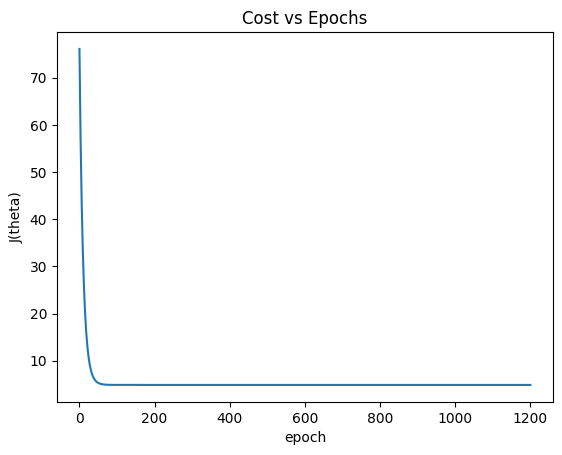

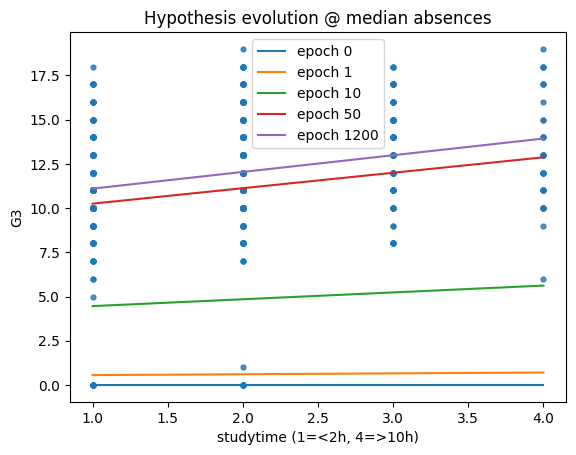

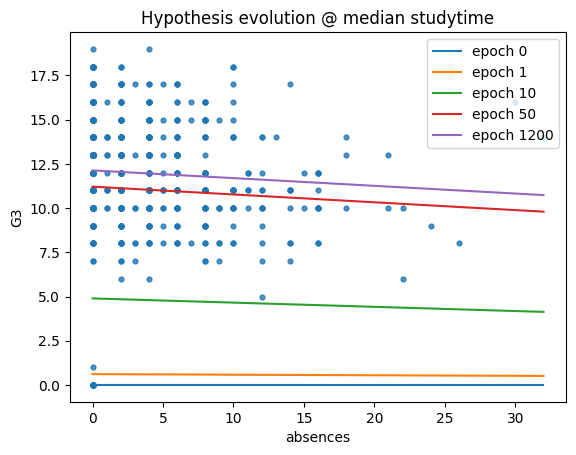

In [7]:
# I only need three columns
# If the file isn't in the Colab runtime, this asks me to upload it.
# Conclusion: more study time has a positive effect on final grades, while more absences have a negative effect

import pandas as pd
import numpy as np

try:
    df = pd.read_csv("student-por.csv", sep=";")
except FileNotFoundError:
    from google.colab import files
    print("Upload student-por.csv (UCI Student Performance, Portuguese).")
    files.upload()
    df = pd.read_csv("student-por.csv", sep=";")

df = df[["studytime", "absences", "G3"]].dropna().reset_index(drop=True)
df.head()

# Standardizing helps gradient descent learn smoothly.
mu_s = df["studytime"].mean()
sd_s = df["studytime"].std(ddof=0) or 1.0
mu_a = df["absences"].mean()
sd_a = df["absences"].std(ddof=0) or 1.0

x1 = (df["studytime"] - mu_s) / sd_s
x2 = (df["absences"]  - mu_a) / sd_a
y  = df["G3"].to_numpy(dtype=float)

# Design matrix with bias term
Xb = np.column_stack([np.ones(len(df)), x1.to_numpy(), x2.to_numpy()])
Xb.shape, y.shape

# Define
def h(Xb, theta):
    return Xb @ theta

def cost(Xb, y, theta):
    e = h(Xb, theta) - y
    return (e @ e) / (2 * len(y))

def step(Xb, y, theta, lr):
    m = len(y)
    e = h(Xb, theta) - y
    grad = (Xb.T @ e) / m
    return theta - lr * grad

#train
alpha  = 0.05
epochs = 1200
theta  = np.zeros(3)             # [bias, w_studytime, w_absences]
check  = [0, 1, 10, 50, 1200]     # snapshots for plots

print("=== Linear Regression: G3 ~ studytime + absences ===")
print("start theta:", theta.tolist())
print("alpha:", alpha, "| epochs:", epochs)
print("start cost:", round(cost(Xb, y, theta), 4))

J_hist = []
snap = {}

for t in range(epochs + 1):
    J_hist.append(cost(Xb, y, theta))
    if t in check:
        snap[t] = theta.copy()
    if t < epochs:
        theta = step(Xb, y, theta, alpha)

print("final theta:", theta.tolist())
print("final cost:", round(J_hist[-1], 4))

#cost curve
import matplotlib.pyplot as plt

plt.plot(J_hist)
plt.xlabel("epoch")
plt.ylabel("J(theta)")
plt.title("Cost vs Epochs")
plt.show()

# Fix absences to the dataset median + vary study time
abs_med = df["absences"].median()
abs_std = (abs_med - mu_a) / sd_a

study_vals = np.array([1, 2, 3, 4], dtype=float)
study_std  = (study_vals - mu_s) / sd_s
Xb_slice1  = np.column_stack([
    np.ones_like(study_std),
    study_std,
    np.full_like(study_std, abs_std)
])

plt.scatter(df["studytime"], df["G3"], s=12, alpha=0.8)
for t in check:
    plt.plot(study_vals, h(Xb_slice1, snap[t]), label=f"epoch {t}")
plt.xlabel("studytime (1=<2h, 4=>10h)")
plt.ylabel("G3")
plt.title("Hypothesis evolution @ median absences")
plt.legend()
plt.show()

#show hypothesis change
study_med = df["studytime"].median()
study_std_med = (study_med - mu_s) / sd_s

abs_grid = np.linspace(df["absences"].min(), df["absences"].max(), 25)
abs_grid_std = (abs_grid - mu_a) / sd_a
Xb_slice2 = np.column_stack([
    np.ones_like(abs_grid_std),
    np.full_like(abs_grid_std, study_std_med),
    abs_grid_std
])

plt.scatter(df["absences"], df["G3"], s=12, alpha=0.8)
for t in check:
    plt.plot(abs_grid, h(Xb_slice2, snap[t]), label=f"epoch {t}")
plt.xlabel("absences")
plt.ylabel("G3")
plt.title("Hypothesis evolution @ median studytime")
plt.legend()
plt.show()

#The hypothesis plots show how the regression line moves from epoch 0 to epoch 1200 as theta changes
